# **Tutorial 2: Filtering and Common Transformations**

In this part, we will learn how to implement basic 'cleaning' and spatio-temporal transformations of the data which are common in an analysis pipeline. We will also cover a few "gotcha"s to keep an eye out for. Furthermore, we show some good practices for 'cleaning' the data from unreliable users and/or pings. 

## Introduction

Researchers often filter geospatial datasets to focus on users or trajectories that meet specific criteria—such as sufficient activity, coverage within a particular timeframe, or presence within defined geographic areas. For example, a study might analyze “users with at least 14 days of activity in January who visited Central Park.” Beyond identifying qualifying users, researchers often need to retrieve these users’ complete trajectories across a wider region to study questions like “Where else do Central Park visitors travel from or to around the world?”

Obviously, this reduces the scope of the analysis and makes the sample small and oftentimes manageable without the need for a cluster. However, to get that sample it might be necessary to implement some filtering at read time. 

Building such filters typically involves handling polygon operations, coordinate system transformations, and reconciling inconsistent formats from various data sources.

Below we show a two step process:

1.	Select users that meet specified geographical and temporal conditions.  
2.	Extract the complete trajectories from those users

## Load Data

For this example, we will use a third dataset different than the one used in part 1, which has more users and, occasionally, denser signals. 

In [1]:
import nomad.io.base as loader

filepath_root = 'gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

traj = loader.from_file(filepath_root, format='parquet', traj_cols=tc)
traj.head()

,gc_identifier,dev_x,dev_y,unix_ts,ha,date
0,admiring_brattain,-4.265481e+06,4.393146e+06,1704106881,10.702426,2024-01-01
1,admiring_brattain,-4.265533e+06,4.393159e+06,1704107003,19.015804,2024-01-01
2,admiring_brattain,-4.265477e+06,4.393185e+06,1704107072,24.851835,2024-01-01
3,admiring_brattain,-4.265490e+06,4.393156e+06,1704107268,10.181171,2024-01-01
4,admiring_brattain,-4.265491e+06,4.393147e+06,1704107349,11.100491,2024-01-01


## Ping Frequency

In [2]:
# We can investigate the frequency of these GPS signals, which can be very sparse
total_pings = traj.groupby(tc['user_id']).size()
total_hours = (traj[tc['timestamp']].max() - traj[tc['timestamp']].min())//3600

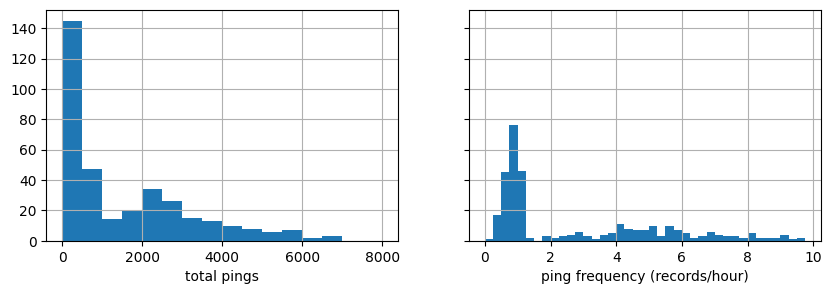

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
pd.set_option("mode.copy_on_write", True)
pd.plotting.register_matplotlib_converters()

fig, (ax1, ax2) = plt.subplots(figsize=(10,3), ncols=2, sharey=True)

total_pings.hist(ax=ax1, bins= [500*b for b in range(17)])
ax1.set_xlabel('total pings')

# x-axis restricted to bins
(total_pings/total_hours).hist(ax=ax2, bins= [0.25*b for b in range(40)])
ax2.set_xlabel('ping frequency (records/hour)')

plt.show()

We note **heterogeneity in the ping frequencies** and the volume of data. However, we musn't assume that *more records* = *more complete signals*. The data is often collected in short bursts, so, there might be users with fewer pings but **more evenly distributed** over the study period (we call this **"higher coverage"**). Furthermore, many pings might have such **high levels of GPS error** (horizontal accuracy), that they shouldn't even be considered in the analysis. Let's filter out innacurate pings and *downsample to a minute resolution*

In [4]:
from nomad import filters

# Remove horizontal accuracy over 50m
traj_ds = traj.loc[traj[tc['ha']] < 50]
print(f"{((traj[tc['ha']]>50).mean()*100).round(3)}% pings have 'ha' > 50m")
# Downsampling pings to once per minute
num_mins=1 # Try 5
traj_ds = filters.downsample(traj_ds, periods=num_mins, verbose=True, traj_cols=tc)

1.715% pings have 'ha' > 50m
11.941% of rows removed by downsampling to 1min windows per user.


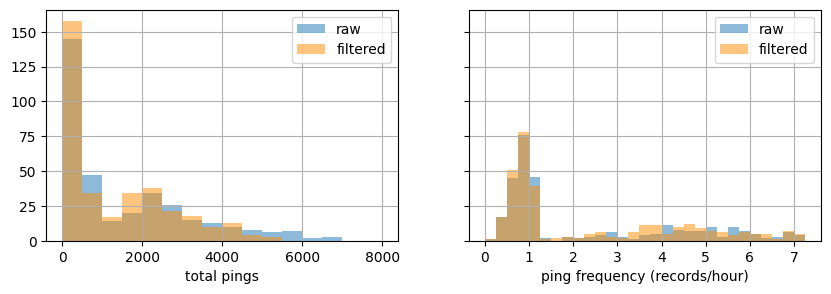

In [5]:
total_pings_filtered = traj_ds.groupby(tc['user_id']).size()

fig, (ax1, ax2) = plt.subplots(figsize=(10,3), ncols=2, sharey=True)

total_pings.hist(ax=ax1, bins= [500*b for b in range(17)], alpha=0.5, label='raw')
total_pings_filtered.hist(ax=ax1, bins= [500*b for b in range(17)], color='darkorange', alpha=0.5, label='filtered')
ax1.legend()
ax1.set_xlabel('total pings')

(total_pings/total_hours).hist(ax=ax2, bins= [0.25*b for b in range(30)], alpha=0.5, label='raw')
(total_pings_filtered/total_hours).hist(ax=ax2, bins= [0.25*b for b in range(30)], color='darkorange', alpha=0.5, label='filtered')
ax2.set_xlabel('ping frequency (records/hour)')
ax2.legend()

plt.show()

`nomad`'s `filters.downsample` method automatically takes care of grouping by user if the name of a user id column is passed (in this case via `traj_cols`), but it would also work for a single trajectory or on a `pandas.datetime64` datetime column if available.

## Spatial filters and Projections

Suppose we are interested in an analysis of users who visited a park during multiple days, e.g. **3 days**, of January 2024. In particular, we might want to know which other locations these users tend to visit to try and get some insights. Naturally, we do this through a spatial join of each user's coordinates with the polygon that represents the park. Here are some possible immediate challenges that could make an analysis `ad-hoc`

- The polygon could be in **spherical coordinates** (also called **geographic coordinates**) and the data in **projected coordinates**. For example, in `(longitude, latitude)` coordinates with `crs='EPSG:4326'`, while the data has ``` (x, y)``` coordinates from the Web Mercator crs (`'EPSG:3857'`).

- The polygon could be represented as a Well-Known-Text string (`wkt`), `shapely` polygon (or multipolygon), or a `Geopandas.GeoSeries`

We can get a `shapely.Polygon` representing the park querying from the file `garden_city.geojson` but, for the sake of completeness, we will assume that the polygon is given by a `wkt`. `geopandas` and `shapely` already wrap easy to use methods for spatial joins.

Add an image of web mercator crs vs geographical coordinates crs

### Load the geometry data

In [6]:
import geopandas as gpd
import pyproj # for coordinate reprojection
from shapely.geometry import Polygon, box

city = gpd.read_file("garden_city.geojson").set_index('building_id')
outer_box = box(*city.total_bounds).buffer(0.00015, join_style='mitre') # "background" box
# poly = city.geometry.loc['p-x13-y11'] #uncomment for comparing

poly_wkt = 'POLYGON ((-38.31767437672955 36.66929877196072, -38.31767437672955 36.66973109167419,'\
                     '-38.31821336590002 36.66973109167419, -38.31821336590002 36.66929877196072,'\
                     '-38.31767437672955 36.66929877196072))'
poly = gpd.GeoSeries.from_wkt([poly_wkt])[0]

### Check if a user has pings inside the park 

We start by analyzing the data from a single user. Checking which pings fall inside a given polygon is trivial with `geopandas.GeoDataFrame.within`. However, the polygon and the passed pings must have the same CRS. Reprojection is also quite simple if we cast our dataset as a `GeoDataFrame`. 

In [7]:
user_df = traj.loc[(traj[tc['user_id']] == 'heuristic_lamport')] # try 'gifted_galileo'
# Cast to GeoDataFrame and reproject (easy)
user_df = gpd.GeoDataFrame(user_df,
                           geometry=gpd.points_from_xy(user_df['dev_x'], user_df['dev_y']),
                           crs='EPSG:3857').to_crs('EPSG:4326')

user_df['in_park'] = user_df.within(poly)
user_df = user_df[user_df.within(outer_box)] # For plotting purposes

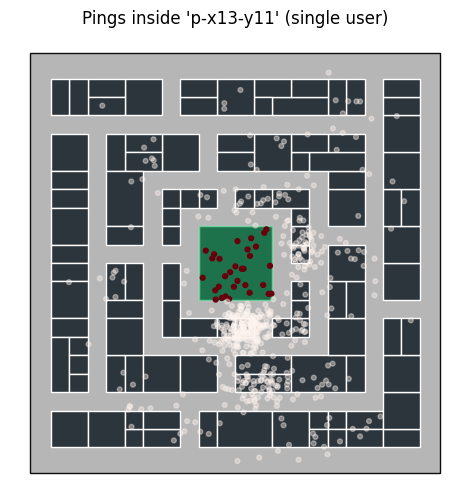

In [8]:
import shapely.plotting as shp_plt
# for pretty plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_axis_off()

shp_plt.plot_polygon(outer_box, ax=ax, add_points=False, color='#0e0e0e')
city.plot(ax=ax, edgecolor='white', color='#2c353c')
shp_plt.plot_polygon(poly, ax=ax, add_points=False, color='#0fad5a', alpha=0.5)
user_df.plot(ax=ax, column='in_park', marker='o', markersize=12, alpha=(0.4+user_df.in_park*0.6), cmap='Reds') # Try cmap='inferno'
ax.set_title("Pings inside 'p-x13-y11' (single user)")

plt.show()

### Qualification constraints: minimum pings and minimum active days

Trajectories are **noisy**, so some of the pings falling within the park might actually come from commuting or visiting buildings in the vicinity. To get *bona-fide* park visitors in the final analysis we need to address this possibiility. Because of sparsity and burstiness, a **simple ping count could be misleading** and not indicative of actual **dwelling** or **stopping** at the location. Let's remove some of the spurious visits by downsampling the pings in the park to **every 20 minutes**. We formulate the new definition for our sample:

**Park Visitors** = users with at least **2 pings** in the park, separated by at least **20 minutes**, in each of, **at least 5 days**. 


<small>
*Properly detecting stops requires some form of clustering in space and time and is explained in the [stop-detection notebook](./[3]stop-detection.ipynb).
</small>

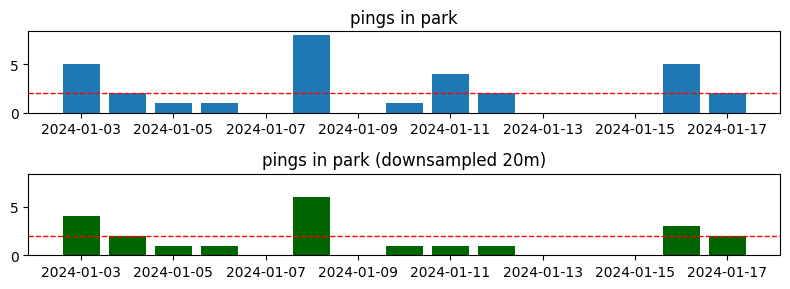

In [9]:
park_pings = user_df.query('in_park == True').groupby('date').size()
park_pings_filtered = filters.downsample(user_df.query('in_park == True'), periods=20, freq='min', **tc).groupby('date').size()

fig, (ax1, ax2) = plt.subplots(figsize=(8,3), nrows=2, sharey=True)

ax1.set_title("pings in park")
ax1.bar(x=park_pings.index, height=park_pings)

ax2.set_title("pings in park (downsampled 20m)")
ax2.bar(x=park_pings_filtered.index, height=park_pings_filtered, color='darkgreen')

[ax.axhline(y=2, linewidth=1, color='r', linestyle='--') for ax in (ax1, ax2)]

plt.tight_layout()
plt.show()

Does our sample user make the cut?

### Qualification constraints: signal completeness (q)

If the data for a user is highly incomplete, then results might not be reliable due to *incompleteness bias*. Imagine trying to analyze whether visitors to the park tend to come back the next day, but one of your 'visitors' only has data every 5 days. We quantify the *completeness* of a user with a statistic, $q$, corresponding to the percentage of 'time buckets' with any pings given by some resolution (e.g. hours or days). Let's compute it for our sample.

Note that:
- $q$ is the average of the hourly "coverage mask" of a user.
- On the other hand, from the *coverage matrix* of all users, we could get the users active each hour (HAU), day (DAU) or monthly (MAU)

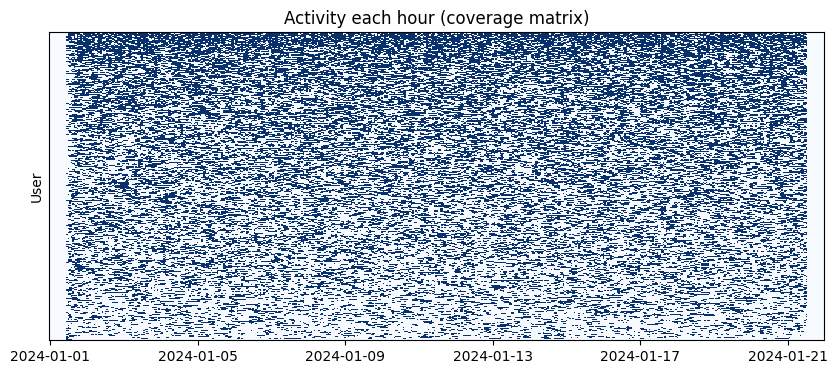

In [10]:
Q = filters.coverage_matrix(traj, periods=1, freq='h', traj_cols=tc, start='2024-01-01', end='2024-01-22', str_from_time=True)
completeness_hourly = Q.mean(1)

fig, ax = plt.subplots(figsize=(10, 4))

Q = Q.iloc[completeness_hourly.argsort(-1)]
Q.columns = pd.to_datetime(Q.columns)

ax.pcolormesh(Q.columns, range(len(Q)), Q.values,               # plot matrix
               cmap='Blues', shading='auto')

ax.set_yticks([])
ax.set_ylabel('User')
ax.set_title('Activity each hour (coverage matrix)')

plt.show()

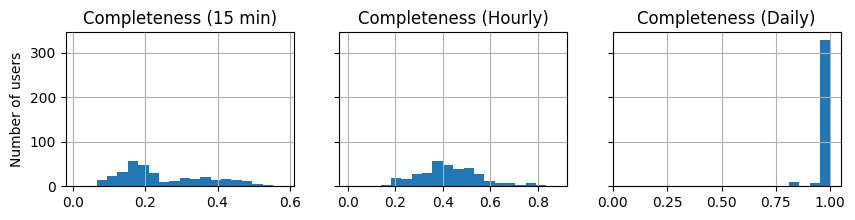

In [11]:
# Let's use one of nomad's wrappers to compute this completeness at different resolutions
q_15m = filters.completeness(traj, periods=15, freq='min', traj_cols=tc)
q_hourly = filters.completeness(traj, periods=1, freq='h', traj_cols=tc)
q_daily = filters.completeness(traj, periods=1, freq='d', traj_cols=tc)

# we visualize them as side by side histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 2))

ax1.hist(q_15m, bins=20)
ax1.set_title('Completeness (15 min)')
ax1.set_ylabel('Number of users')


ax2.hist(q_hourly, bins=20)
ax2.set_title('Completeness (Hourly)')

ax3.hist(q_daily, bins=20)
ax3.set_title('Completeness (Daily)')

[ax.grid() for ax in (ax1, ax2, ax3)]
plt.show()

It seems like users have excellent daily completeness, but several hour gaps. Let's keep only users that have `q_hourly>0.4`

## Putting it all together

Let's implement the filtering and cleaning that will define our sample of users in our analysis of parks with some chained statements

In [12]:
# ingest
tc = {"user_id": "gc_identifier", "timestamp": "unix_ts", "x": "dev_x", "y": "dev_y", "ha":"ha", "date":"date"}
traj = loader.from_file('gc_data_long/', format='parquet', traj_cols=tc)

# let's rename the columns to get default names
tc_reverse = {v:k for k,v in tc.items()}
traj.rename(columns=tc_reverse, inplace=True)

In [14]:
poly_wkt = 'POLYGON ((-38.31767437672955 36.66929877196072, -38.31767437672955 36.66973109167419,'\
                     '-38.31821336590002 36.66973109167419, -38.31821336590002 36.66929877196072,'\
                     '-38.31767437672955 36.66929877196072))'

# Visitors to the park
traj_clean = filters.downsample(traj.query('ha < 50'), periods=1, freq='min')

# at least 2 pings 20 minutes apart each day of at least 5 days
pings_in_poly = filters.within(traj_clean, within=poly_wkt, x='x', y='y', data_crs='EPSG:3857', poly_crs='EPSG:4326')

days_w_2_pings = (
    filters.downsample(pings_in_poly, periods=20, freq='min')
    .groupby(['user_id', 'date']).size().reset_index(name='pings')  # <<< count pings per userxdate
    .query('pings >= 2') # <<< filter
)

park_visitors = days_w_2_pings.groupby('user_id').size().loc[lambda s: s >= 5].index # <<< park visitors

# completeness > 0.4
user_sample = filters.completeness(traj_clean.query('user_id in @park_visitors'), periods=1, freq='h').loc[lambda s: s>0.4].index

## Which locations do these users visit?

In [19]:
import nomad.visit_attribution as visits
import nomad.stop_detection.grid_based as stop_detection

data_sample = traj_clean.query('user_id in @user_sample')
data_sample['building_id'] = visits.poi_map( data_sample, poi_table=city, data_crs='EPSG:3857', x='x', y='y')

stop_detection.

C:\Users\franc\Documents\Nomad\nomad-repo\nomad\visit_attribution.py:212: UserWarning: CRS for `poi_table` does not match crs for `data`. Reprojecting...
  warnings.warn("CRS for `poi_table` does not match crs for `data`. Reprojecting...")
C:\Users\franc\Documents\Nomad\nomad-repo\nomad\visit_attribution.py:223: UserWarning: location_id column not provided, defaulting to poi_table.index for spatial join.
  warnings.warn(f"location_id column not provided, defaulting to poi_table.index for spatial join.")


,user_id,x,y,timestamp,ha,date,building_id
1488,admiring_curie,-4.265424e+06,4.393116e+06,1704135585,13.433555,2024-01-01,NaN
1489,admiring_curie,-4.265432e+06,4.393123e+06,1704135923,8.984719,2024-01-01,w-x18-y8
1491,admiring_curie,-4.265436e+06,4.393121e+06,1704136140,8.070809,2024-01-01,w-x18-y8
1492,admiring_curie,-4.265420e+06,4.393134e+06,1704136295,17.392330,2024-01-01,NaN
1493,admiring_curie,-4.265428e+06,4.393121e+06,1704136548,11.600870,2024-01-01,NaN
...,...,...,...,...,...,...,...
563041,youthful_wilson,-4.265584e+06,4.393195e+06,1705835216,10.405844,2024-01-21,h-x7-y15
563042,youthful_wilson,-4.265581e+06,4.393195e+06,1705836196,12.841817,2024-01-21,h-x7-y15
563043,youthful_wilson,-4.265578e+06,4.393213e+06,1705836739,22.435931,2024-01-21,NaN
563044,youthful_wilson,-4.265583e+06,4.393186e+06,1705836927,11.673936,2024-01-21,h-x6-y13


## Applying filters on read

If your dataset is too large. Loading it all in memory to then apply the filters can be intractable. Nomad implements these functionalities to filter in this way on read...